In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np

import json
import glob
import random
import pickle
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
import torch.nn.functional as F
import spotPython.torch.netcore as netcore
from numpy import meshgrid, array, ravel

from src.eda import EDA
eda = EDA()

In [2]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)

In [3]:
pio.templates.default = "plotly_white"
pio.renderers.default='notebook'
plotly.offline.init_notebook_mode(connected=True)

In [4]:
colors = ['#46039f','#9c179e','#d8576b','#fb9f3a']

class FashionCNN(nn.Module):
    def __init__(self, l1=64):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net_FashionMNIST(netcore.Net_Core):
    def __init__(self, l1, lr_mult, batch_size, epochs, k_folds, patience,
    optimizer, sgd_momentum):
        super(Net_FashionMNIST, self).__init__(
            lr_mult=lr_mult,
            batch_size=batch_size,
            epochs=epochs,
            k_folds=k_folds,
            patience=patience,
            optimizer=optimizer,
            sgd_momentum=sgd_momentum,
        )

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])

    trainset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=True,
        transform=transform)
    testset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=False,
        transform=transform)

    return trainset, testset

def train_fashion_mnist(config):
    net = FashionCNN(config["config.l1"]) 

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    # # loading data
    trainset, testset = load_data()
    
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=config["config.batch_size"], shuffle=True, num_workers=2
    )

    # defining the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["config.learning_rate"])

    for epoch in range(config["config.epochs"]):
        running_loss = 0.0
        epoch_steps = 0
        with tqdm(enumerate(trainloader, 0), total=len(trainloader), unit="batch") as epoch_iterator:
            for i, data in epoch_iterator:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                epoch_steps += 1

                if i % 1000 == 999:
                    average_loss = running_loss / epoch_steps
                    epoch_iterator.set_description(f"Epoch {epoch+1}, Loss: {average_loss:.3f}")
                    running_loss = 0.0
            

    print("Training finished.")
    return net

def test_accuracy(net):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def test_class_accuracy(net):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct_per_class = [0] * len(class_names)
    total_per_class = [0] * len(class_names)
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                if label == prediction:
                    correct_per_class[label] += 1
                total_per_class[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy_per_class = [correct / total * 100 if total > 0 else 0 for correct, total in zip(correct_per_class, total_per_class)]

    for i, accuracy in enumerate(accuracy_per_class):
        print('Accuracy of {}: {:.2f}%'.format(class_names[i], accuracy))
        
    accuracy = correct / total
    print('Overall Accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy_per_class, accuracy

eval_data_path = './evaluation_data/'

def experimentPathToDataframe(experiment_path):
    df_results = pd.DataFrame()
    for file in glob.iglob(experiment_path + '/**/result.json', recursive=True):
        print(f"Loading results from {experiment_path}...")

        df = pd.read_json(file,lines=True)
        data = json.loads(df.to_json(orient='records'))
        df = pd.json_normalize(data, max_level=1)
        df_results = pd.concat([df_results, df], ignore_index=True)

    print(f"----------------------------\nFound {len(df_results.trial_id.unique())} trials.")
    return df_results

def experimentPathToSpotTuner(experiment_path):
    with open(experiment_path, 'rb') as f:
        spot_tuner =  pickle.load(f)
    return spot_tuner

def spotTunerToDataFrame(spotTuner):
    df = pd.DataFrame(np.concatenate((spotTuner.X, spotTuner.y.reshape(-1, 1)), axis=1), columns=spotTuner.var_name + ["y"])
    df['l1'] = df['l1'].apply(lambda x: int(2**x))
    df['lr_mult'] = df['lr_mult'].apply(lambda x: x*1e-3)
    df['batch_size'] = df['batch_size'].apply(lambda x: int(2**x))
    df['epochs'] = df['epochs'].apply(lambda x: [5, 10, 15, 20][int(x)])
    df = df.rename(columns={'l1': 'config.l1', 
                            'lr_mult': 'config.learning_rate',
                            'batch_size': 'config.batch_size',
                            'epochs': 'config.epochs',
                            'y': 'mean_val_loss'})
    print(f"----------------------------\nFound {len(df)} trials.")
    return df

def bestConfig(df):
    df_tmp = df.groupby('trial_id').max('training_iteration').reset_index()
    df_tmp = df_tmp[df_tmp['mean_val_loss'] == df_tmp['mean_val_loss'].min()]
    best_config = df_tmp[['mean_val_loss', 'mean_accuracy', 'config.l1', 'config.batch_size', 'config.epochs', 'config.learning_rate']].to_dict(orient='records')[0]
    # for key, value in best_config.items():
    #     print(f'{key}: {value}') 
    return best_config

def bestConfigSpot(spotTuner):
    results = spotTuner.print_results(print_screen=False)
    best_config = {
        'mean_val_loss': None,
        'mean_accuracy': None,
        'config.l1': None,
        'config.batch_size': None,
        'config.epochs': None,
        'config.learning_rate': None,
    }
    for conf in results:
        if conf[0] == 'l1':
            best_config['config.l1'] = int(2**conf[1])
        elif conf[0] == 'batch_size':
            best_config['config.batch_size'] = int(2**conf[1])
        elif conf[0] == 'epochs':
            best_config['config.epochs'] = [5, 10, 15, 20][int(conf[1])]
        elif conf[0] == 'lr_mult':
            best_config['config.learning_rate'] = conf[1] * 1e-3
    return best_config

def repeatedTraining(config, iter, file_name):
    res = []
    for i in range(iter):
        torch.manual_seed(i)
        random.seed(i)
        np.random.seed(i)
        score = {'name': file_name}
        net = train_fashion_mnist(config)
        class_acc, acc = test_class_accuracy(net)
        for val, name in zip(class_acc,class_names):
            score[name] = val
        score['overall'] = acc
        res.append(score)
        df = pd.DataFrame(res)
        df.to_csv(f'./results/evaluation_data/{file_name}.csv')
    return df

In [5]:
## Load Data
df_e2 = pd.read_csv(f'{eval_data_path}/tuning_logs/e2.csv', index_col=0)
df_e2[['config.learning_rate']] = df_e2[['config.learning_rate']].astype(float)
idx = df_e2.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e2 = df_e2.loc[idx,]

df_e3 = pd.read_csv(f'{eval_data_path}/tuning_logs/e3.csv', index_col=0)
df_e3[['config.learning_rate']] = df_e3[['config.learning_rate']].astype(float)
idx = df_e3.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e3 = df_e3.loc[idx,]

df_e4 = pd.read_csv(f'{eval_data_path}/tuning_logs/e4-1.csv', index_col=0)
df_e4[['config.learning_rate']] = df_e4[['config.learning_rate']].astype(float)
idx = df_e4.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e4 = df_e4.loc[idx,]

df_e5 = pd.read_csv(f'{eval_data_path}/tuning_logs/e5-1.csv', index_col=0)
df_e5[['config.learning_rate']] = df_e5[['config.learning_rate']].astype(float)
idx = df_e5.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e5 = df_e5.loc[idx,]

df_e6 = pd.read_csv(f'{eval_data_path}/tuning_logs/e6-1.csv', index_col=0)
df_e6[['config.learning_rate']] = df_e6[['config.learning_rate']].astype(float)
idx = df_e6.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e6 = df_e6.loc[idx,]

df_e6_log = pd.read_csv(f'{eval_data_path}/tuning_logs/e6.csv', index_col=0)
df_e6_log[['config.learning_rate']] = df_e6_log[['config.learning_rate']].astype(float)
idx = df_e6_log.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e6_log = df_e6_log.loc[idx,]

df_e7 = pd.read_csv(f'{eval_data_path}/tuning_logs/e7-1.csv', index_col=0)
df_e7[['config.learning_rate']] = df_e7[['config.learning_rate']].astype(float)
idx = df_e7.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e7 = df_e7.loc[idx,]

df_e7_log = pd.read_csv(f'{eval_data_path}/tuning_logs/e7.csv', index_col=0)
df_e7_log[['config.learning_rate']] = df_e7_log[['config.learning_rate']].astype(float)
idx = df_e7_log.groupby('trial_id')['training_iteration'].idxmax()
df_flat_e7_log = df_e7_log.loc[idx,]

default_reps = pd.read_csv(f'{eval_data_path}/reps/default_reps.csv', index_col=0)
e6_reps = pd.read_csv(f'{eval_data_path}/reps/e6-1_reps.csv', index_col=0)
e7_reps = pd.read_csv(f'{eval_data_path}/reps/e7-1_reps.csv', index_col=0)
e8_reps = pd.read_csv(f'{eval_data_path}/reps/e8-1_reps.csv', index_col=0)

spotTuner_e8 = experimentPathToSpotTuner("experiment_data/e8_spotPython/spot_runs_30-08-2023.pkl")
df_flat_e8 = pd.read_csv(f'{eval_data_path}/tuning_logs/e8-1.csv', index_col=0)

In [6]:
default_config = {
    'mean_val_loss': None,
    'mean_accuracy': None,
    'config.l1': 64,
    'config.batch_size': 64,
    'config.epochs': 15,
    'config.learning_rate': 0.001,
}

configs = [default_config,
           bestConfig(df_e6),
           bestConfig(df_e7),
           bestConfigSpot(spotTuner_e8)]

df = pd.DataFrame(configs)[['config.l1', 'config.batch_size', 'config.epochs', 'config.learning_rate']]
df.index = ['Default', 'Hyperband', 'Random Search', 'SMBO']
df['trials'] = ['-', f'{len(df_flat_e6)} (~6h)', f'{len(df_flat_e7)} (~6h)', f'{len(df_flat_e8)} (~6h)']
df = df.sort_values(by=['config.l1','config.learning_rate'])
df.columns = ['L1 Units', 'Batch Size', 'Epochs', 'Learning Rate', '# Trials']
#df.to_csv(f'{eval_data_path}/best_config.csv', index=True)

<span style="color: #ff6900; font-size: 45px; font-weight: bold;">Achieving Fashionable Accuracy: Hyperparameter Tuning in Fashion MNIST</span>
<br>

<p style="font-size: 20px; margin-bottom: 5%;">Lena Hammerer, Luisa Ibele, Isabel Janez, Judith Romer, Hanna Steinwender</p>
<br>
<br>
<table style="border-collapse: collapse; border: none; width: 100%; margin-left: 0; padding-left: 0;">
  <tr style="border: none;">
    <td style="border: none; width: 8%; font-size: 18px;"><b>Lecture</b></td>
    <td style="border: none; font-size: 18px;">Aktuelle Data Science Entwicklungen</td>
  </tr>
  <tr style="border: none;  background-color: white;">
    <td style="border: none; font-size: 18px;"><b>Lecturer</b></td>
    <td style="border: none; font-size: 18px;">Prof. Dr. Martin Zaefferer</td>
  </tr>
  <tr>
    <td style="border: none;"></td>
    <td style="border: none; text-align: right; font-size: 18px;">06.09.2023</td>
</table>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Procedure</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<br>
<img src="images/crisp-dm.png" width="650px" style="margin-left: auto; margin-right: auto; display: block;">
<footer style="font-size: 10px;">
<p>[1] https://www.kobold.ai/crisp-dm/ </p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Business Understanding</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<p style="font-size: 18px;"><i>Discussing and Understanding the Use Case</i></p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Goal of the Hyperparameter Tuning Project</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>

- Chosen problem from the field of Machine Learning (dataset, model, parameters)
- Solve the problem, with empirical investigation, using the approaches from the lecture 

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Dataset: Fashion-MNIST</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<ul>
  <li>Image dataset for benchmarking Machine Learning algorithms</li>
  <li>Drop-in replacement of MNIST dataset</li>
  <li>Dataset based on Zalando's product diversity for men, women, children and neutral</li>
  <li>Contains article images with labels of 10 classes</li>
  <li>Training set of 60.000 examples and test set of 10.000 examples</li>
  <li>Image formats:</li>
  <ul>
    <li>28x28 grayscale images</li>
    <li>No white products due to low contrast to background</li>
    <li>Images in different resolutions for frontend components</li>
  </ul>
</ul>

<br>
<footer style="font-size: 10px;">
<p>[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: cs.LG/1708.07747 </p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <p style="color: #ff6900; font-weight: bold; font-size: 25px;">Why was the Fashion-MNIST dataset created?</p>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>

- Original MNIST dataset: handwritten digits
- MNIST is often used as benchmark to validate algorithms 
- MNIST is too easy, overused and can not represent modern Computer Vision tasks
- Fashion-MNIST intended to serve as a direct drop-in replacement, sharing same images size and the structure of training and testing splits

<br>
<p style="color: #ff6900; font-weight: bold; font-size: 25px;">The aim of Fashion-MNIST dataset</p>

- Good benchmark dataset
- Accessibility of MNIST: small size, straightforward encoding and permissive license
- A more challenging classification task

<br>

<footer style="font-size: 10px;">
<p>[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: cs.LG/1708.07747 </p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Overview of the Dataset</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>

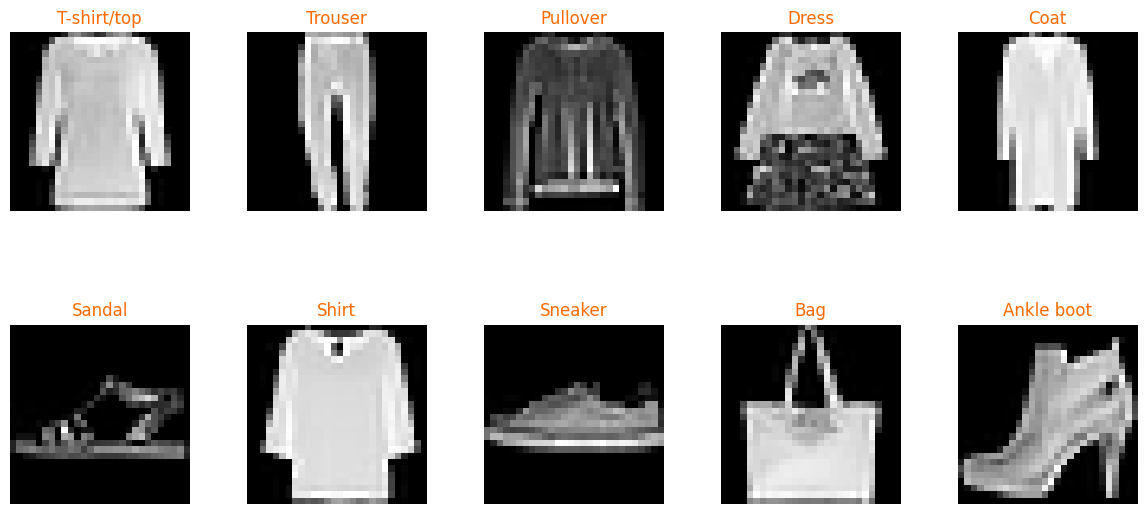

In [7]:
eda.display_random_images()

zu erwähnen:
- Größe Datensatz
- beispielhafte Bilder
- wie Aufbau von Datensatz
- Balance der Klassen
- Pixel Angaben nennen

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Data Understanding</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<p style="font-size: 18px;"><i>Identification and Exploratory Analysis of Appropriate Data</i></p>

In [8]:
trainset, testset = eda.load_data()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Class Distribution</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>

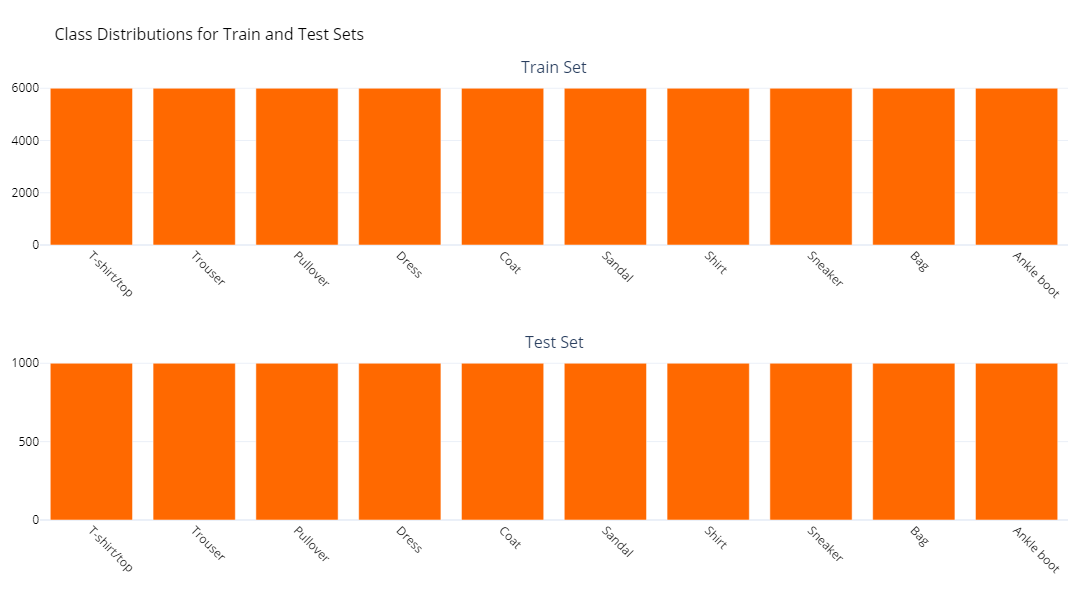

In [9]:
eda.plot_class_distribution(trainset, testset)

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Average Black Pixels</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>

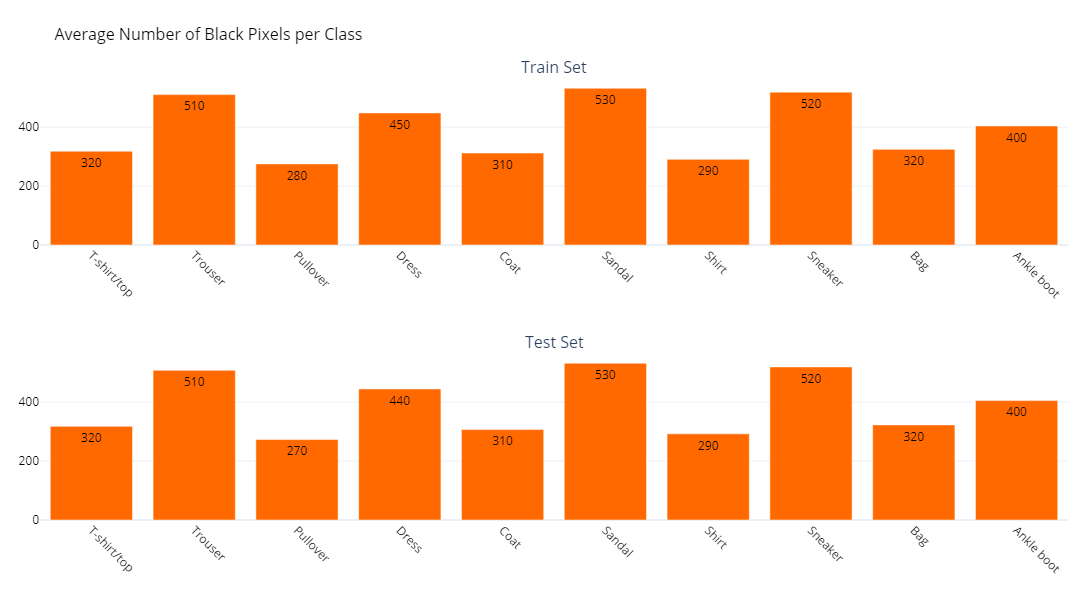

In [10]:
eda.display_average_black_pixels(trainset, testset)

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Data Preparation</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<p style="font-size: 18px;"><i>Consolidation and Cleaning of Data, Feature Engineering</i></p><br>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Image Preparation</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<ul>
    <li>Balanced Dataset</li>
    <li>Limited Resources</li>
    <li>Clean Dataset</li>
    <li>Prioritizing Simplicity and Speed</li>
</ul>
<p style="margin-left: 1%;">&#8680; No explicit need for Data Preparation in this case</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Training, Validation and Test Split</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<ul>
    <li>Dataset already divided into a training set and a test set</li>
    <li>Splitting the training set into 80% training and 20% validation subsets</li> 
    <li>Using random splitting to ensure unbiased representation</li>
</ul>

In [11]:
# Split the training set into subsets
# test_abs = int(len(trainset) * 0.8)
# train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

# # Create data loaders for subsets
# trainloader = torch.utils.data.DataLoader(
#     train_subset, batch_size=64, shuffle=True, num_workers=2
# )
# valloader = torch.utils.data.DataLoader(
#     val_subset, batch_size=64, shuffle=True, num_workers=2
# )

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Modeling</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<p style="font-size: 18px;"><i>Use of Machine Learning or other Data Mining Algorithms</i></p><br>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Metrics</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px;">Accuracy</p>

- Measures the proportion of correctly classified data

- Accuracy = $(\frac{\text{Number of correct predictions}}{\text{Total number of predictions}}) * 100$
- Simple interpretation - especially for balanced class distribution
- Balanced Accuracy not required as data classes are balanced

<p style="color: #ff6900; font-weight: bold; font-size: 25px;">Cross Entropy</p>

- Measure of the differences between probability distributions

- Minimization leads to approximation of model predictions to true class distributions
- Promotes high probabilities for true classes and low probabilities for false classes
- $\text{Loss} = − \sum\limits_{i=0}^{n} (y⋅log(p)+(1−y)⋅log(1−p))$ 

<br>
<footer style="font-size: 10px;">
<p>[1] Grandini, M., Bagli, E. and Visani, G., 2020. Metrics for multi-class classification: an overview. arXiv preprint arXiv:2008.05756.<br>
[2] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.<br>
[3] Zhang, Z. and Sabuncu, M., 2018. Generalized cross entropy loss for training deep neural networks with noisy labels. Advances in neural information processing systems, 31.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Architecture</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer | Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

<p style="color: #ff6900; font-weight: bold; font-size: 25px">Convolutional Neural Network (CNN)</p><br>
<img src="images/architecture.png" width="100%" style="margin-left: auto; margin-right: auto; display: block;">
<br>
<br>
<span style="font-weight: bold; font-size: 20px;">Initial Setup</span>
<ul>
    <li>Optimizer: Stochastic Gradient Descent (momentum: 0)</li>
    <li>learning_rate: 1e<sup>-3</sup> (0.001)</li>
    <li>batch_size: 64</li>
    <li>epochs: 15</li>
</ul>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="font-weight: bold; font-size: 20px;">Why use a CNN to train ML models on the Fashion-MNIST dataset?</span>
    <span style="text-align: right; font-size: 12px;">Isabel Janez | Judith Romer | Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Trained to identify the edges of objects in any image
- Can process large amounts of data and produce highly accurate predictions
- Can learn the features of an object through multiple iterations, eliminating the need for manual feature engineering tasks like feature extraction
- Very effective in reducing the number of parameters without losing on the quality of models, which makes it suitable for handling images because of their high dimensionality
- Plays an important role in classification of images and image segmentation due to its great performance in different problems

<br>
<footer style="font-size: 10px;">
<p>[1] Meshkini, K., Platos, J. and Ghassemain, H., 2020. An analysis of convolutional neural network for fashion images classification (fashion-mnist). In Proceedings of the Fourth International Scientific Conference “Intelligent Information Technologies for Industry”(IITI’19) 4 (pp. 85-95). Springer International Publishing.<br>
[2] M. Kayed, A. Anter and H. Mohamed, "Classification of Garments from Fashion MNIST Dataset Using CNN LeNet-5 Architecture," 2020 International Conference on Innovative Trends in Communication and Computer Engineering (ITCE), Aswan, Egypt, 2020, pp. 238-243, doi: 10.1109/ITCE48509.2020.9047776.<br>
[3] Mishra, Prafful (2019): Why are Convolutional Neural Networks good for image classification? In: DataDrivenInvestor (27.05.2019) - URL https://medium.datadriveninvestor.com/why-are-convolutional-neural-networks-good-for-image-classification-146ec6e865e8, Accessed: 31.08.2023.</p>

- CNN: fully connected feed forward neural network

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Hyperparameters</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px">Learing Rate</p>

- Affects weight updates after each training step
- Controls loss gradient backtracking during weight updates
- <b>Range:</b> learning_rate &#8712; (0, &infin;); lower bound: 1e-6; upper bound: 1e-2
- <b>Too low learning rate:</b> slow convergence
- <b>Too high learning rate:</b> divergence
- <b>Optimal learning rate:</b> fast convergence with few iterations
- Adaptive methods adjust learning rate based on accuracy or gradient
- Non-adaptive methods use constant or stepwise learning rate schedules
- <b>Cyclic learning rate:</b> varies cyclically between predefined thresholds
- <b>Goal:</b> Better balance between accuracy and loss

<br>
<footer style="font-size: 10px;">
<p>[1] Johny, A. and Madhusoodanan, K.N., 2021. Dynamic learning rate in deep CNN model for metastasis detection and classification of histopathology images. Computational and Mathematical Methods in Medicine, 2021, pp.1-13.<br>
[2] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>


<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px">Epochs</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Determines the number of iterations of the learning algorithm over the entire training dataset
- Each example in the dataset is given an opportunity to update the model parameters
- Includes one or more batches
- One run over the whole dataset is organised in epochs
- <b>Small number of epochs:</b> network is sensitive to changes
- <b>Large number of epochs:</b> convergence and minimisation of model error, better for models quality, but not good for runtime
- <b>Range:</b> epochs &#8712; [1, &infin;)

<br>
<footer style="font-size: 10px;">
<p>[1] Brownlee, J., 2018. What is the Difference Between a Batch and an Epoch in a Neural Network. Machine Learning Mastery, 20.<br>
[2] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px">Batch Size</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Size of the subset of the training dataset that is used simultaneously when determining the gradient of the network weights
- Enables parallel weight updates in training
- Affects the runtime of the training and quality of the model
- <b>Smaller batch_size:</b> increased noise in training, might hinder the learning process
- <b>Larger batch_size:</b> more memory and processing power required
- Selection of the optimal batch size requires trade-off between noise and resources
- <b>Range:</b> batch_size &#8712; (1, <i>n</i> ]

<br>
<footer style="font-size: 10px;">
<p>[1] Brownlee, J., 2018. What is the Difference Between a Batch and an Epoch in a Neural Network. Machine Learning Mastery, 20.<br>
[2] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px">L1 Architecture Parameter (Linear Layer Units)</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

<ul>
    <li>Tuning the linear, fully connected layers of the CNN</li>
    <li>Determines the size of the corresponding network layer</li>
    <li>Significant impact on the network's performance</li>
    <li>Linear layers are typically responsible for making final predictions or decisions</li>
    <li><b>High value for l1:</b> complex model, more model coefficients, higher runtime, but possibly higher model quality and higher risk of overfitting
    <li><b>Range:</b> units &#8712; [1, &infin;)
</ul>
<br>
<footer style="font-size: 10px;">
<p>[1] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px; width: 80%;">What is Neural Architecture Search vs. Classic Hyperparameter Tuning</span><br>
    <span style="text-align: right; font-size: 12px; width: 20%;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

<span style="font-weight: bold; font-size: 20px;">Neural Architecture Search:</span>

- automated process of discovering the optimal neural network architecture for a specific machine learning task
- usage of search algorithms to explore a predefined search space of possible architectures and find the one that performs best on a given dataset and task

<br>
<span style="font-weight: bold; font-size: 20px;">Classic Hyperparameter Tuning:</span>

- the process of systematically searching for the best hyperparameters for a machine learning model, typically after a fixed model architecture has been chosen
- settings that control aspects of the model's training and behavior but are not learned from the data
- more the focus of this project, tuning on parameters: learning rate, epochs, batch size

<br>
<footer style="font-size: 10px;">
<p>[1] White, C., Safari, M., Sukthanker, R., Ru, B., Elsken, T., Zela, A., Dey, D. and Hutter, F., 2023. Neural architecture search: Insights from 1000 papers. arXiv preprint arXiv:2301.08727.<br>
[2] Tuba, E., Bačanin, N., Strumberger, I. and Tuba, M., 2021. Convolutional neural networks hyperparameters tuning. In Artificial intelligence: theory and applications (pp. 65-84). Cham: Springer International Publishing.<br>
[3] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px">Further Parameters</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Optimizer
- Dropout
- Activation function
- Architecture

<br>
<footer style="font-size: 10px;">
<p>[1] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</p>

zu erwähnen:
- warum die Parameter nicht in Erwägung gezogen wurden

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Tuning Approaches</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

What different behaviors can be observed in the approaches?

<p style="color: #ff6900; font-weight: bold; font-size: 25px">Random Search</p>

randomly and repeatedly choosing hyperparameters to evaluate <sup>[1][2]</sup>
- model-free undirected search approach
- baseline to compare with other approaches in experiment setup
- preferable to Grid Search for high-dimensional spaces and heterogenous parameter importance

<img style="margin-left: auto; margin-right: auto; display: block;" src="images/randomSearch_gridSearch.png" width="50%">

<p style="color: #ff6900; font-weight: bold; font-size: 25px">Hyperband Algorithm</p>

multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive halving to stop poorly performing configurations <sup>[3][4]</sup>
- model-free undirected search approach
- employs early stopping criteria (e.g., validation loss improvement) during training 
- allocates more resources (e.g., training epochs) to promising configurations and terminates poorly performing ones early
- efficiently identify the best-performing configurations within a given budget, avoiding wasteful computation

<img style="margin-left: auto; margin-right: auto; display: block;" src="images/hyperband.png" width="60%">

<p style="color: #ff6900; font-weight: bold; font-size: 25px">Surrogate Model Based Optimization (SMBO)</p>

using the Sequential Parameter Optimization Toolkit (SPOT) <sup>[1][5]</sup>
- model-based directed search
- information gathered during search to learn relationship between hyperparameters/performance
- constructs a surrogate and looks for its minimum
- computational effort can be shifted from real evaluations to evaluations of the surrogate
- understanding hyperparameter importance and interactions between several hyperparameters

<img style="margin-left: auto; margin-right: auto; display: block;" src="images/smbo.png" width="60%">

<br>
<footer style="font-size: 10px;">
<p>[1] Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 71-78). Springer Nature. <br>
[2] Bergstra, James, and Y. Bengio. “Random Search for Hyper-Parameter Optimization.” The Journal of Machine Learning Research 13 (March 2012): 281–305.<br>
[3] Li, Lisha, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, and Ameet Talwalkar. “Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization.” June 18, 2018.<br>
[4] Li, Lisha, Kevin Jamieson, Afshin Rostamizadeh, Katya Gonina, Moritz Hardt, Benjamin Recht, and Ameet Talwalkar. “Massively Parallel Hyperparameter Tuning,” February 15, 2018.<br>
[5] Bartz-Beielstein, Thomas. “PyTorch Hyperparameter Tuning - A Tutorial for SpotPython.” June 7, 2023.</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Experiment Setup</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px">Computational Resources and Utilized Technologies</p>

<table style="border: none; font-size:16px">
  <tr style="border: none;">
    <td style="border: none"><b>Hardware (Bizon "Deep Learning Server"):</b></td>
    <td style="border: none"><b>Software:</b></td>
  </tr>
  <tr style="border: none; background-color: white;">
    <td style="border: none">
    <ul>
      <li>CPU: 4 x Intel(R) Xeon(R) Silver 4210 CPU @ 2.20GHz (10 cores, 2.2 GHz)</li>
      <li>GPU: 8 x NVIDIA GeForce RTX 2080 Ti (11 GB VRAM)</li>
      <li>Memory: 125 GB DDR4 RAM</li>
      <li>Storage: 0.5 TB NVMe SSD</li>
    </ul>
    </td>
    <td style="border: none">
      <ul>
        <li>Operating System: Ubuntu 20.04 LTS</li>
        <li>Programming Language: Python 3.10</li>
        <li>ML Libraries: PyTorch 2.0.1, raytune 2.6.3, spotPython 0.6.16</li>
        <li>Additional Software: Jupyter Notebook, Tensorboard</li>
      </ul>
    </td>
  </tr>
</table>

<img style="margin-left: auto; margin-right: auto;" src="images/logos.png" width="60%">

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px">Hyperparameter Search Spaces</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="font-weight: bold; font-size: 20px;">Configuration for Tuning Experiments</p>

| Hyperparameter | Lower Bound | Upper Bound |
| -------------- | ----------- | ----------- |
| L1 Units       | 32          | 256         |
| Batch Size     | 16          | 128         |
| Epochs         | 5           | 20          |
| Learning Rate  | 1e<sup>-4</sup>| 1e<sup>-1</sup>       |

<br>

- **Tuning Approaches**: Random Search, Hyperband (RayTune), SMBO (spotPython)
- **Duration**: Each Tuning Approach run for 6 hours
- **Reproducibility**: Seed for random generators

<br>
<footer style="font-size: 14px;">
<p>Code available at: https://github.com/LuisaIb/fashion-tuning/</p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Evaluation</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="font-size: 18px;"><i>Verification of Predictive Accuracy and Coverage of the Use Case</i></p>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Tuning Results</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px;">Best Configurations</p>

- more _Units_,
- smaller _Batch Size_,
- not a lot of _Epochs_ needed since ...
- ... fairly high _Learning Rate_!

In [12]:
pd.read_csv(f'{eval_data_path}/best_config.csv', index_col=0)

,L1 Units,Batch Size,Epochs,Learning Rate,# Trials
Default,64,64,15,0.001000,-
Random Search,128,16,10,0.054035,87 (~6h)
Hyperband,128,16,15,0.098538,340 (~6h)
SMBO,256,32,10,0.091179,68 (~6h)


<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="font-weight: bold; font-size: 20px;">#️ of Trials - Why does it differ so much?</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Hyperband algorithm focuses resources on promising configurations by combining random sampling and early elimination of poor configurations. More combinations can be tested with the same amount of resources (time).

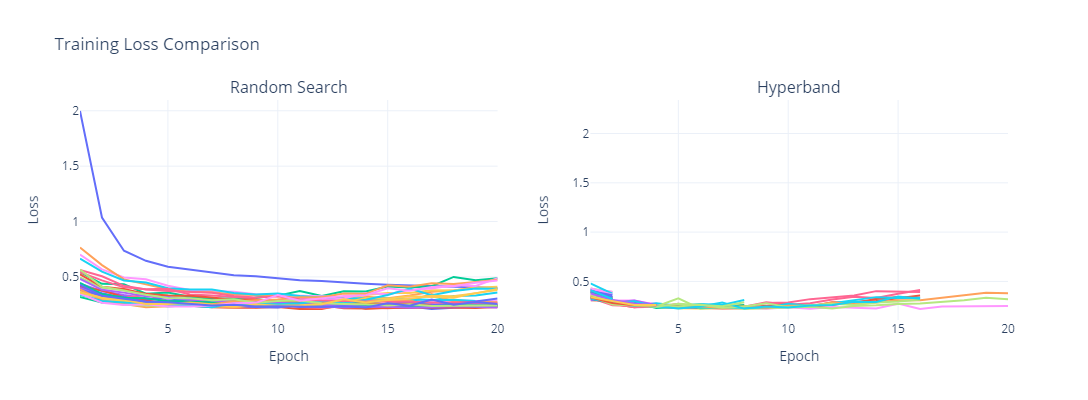

In [13]:
e7_grouped = df_e7.groupby('config.epochs')
df7 = e7_grouped.get_group(20)

e6_grouped = df_e6.groupby('config.epochs')
df6 = e6_grouped.get_group(20)

fig = make_subplots(rows=1, cols=2, subplot_titles=["Random Search", "Hyperband"])

for trial in df7['trial_id'].unique().tolist():
    df = df7[df7['trial_id'] == trial]
    fig.add_trace(go.Scatter(x=df['training_iteration'], y=df['mean_val_loss'], mode='lines'), row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)

for trial in df6['trial_id'].unique().tolist():
    df = df6[df6['trial_id'] == trial]
    fig.add_trace(go.Scatter(x=df['training_iteration'], y=df['mean_val_loss'], mode='lines'), row=1, col=2)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.update_layout(title_text="Training Loss Comparison", showlegend=False, width=900, height=400)

fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Hyperparameter Interdependencies</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px;">Overview Tested Configurations</p>

- **Hyperband** is biased due to early termination of unpromising trials. Trials starting out with high loss cannot reach their full potential as they are not trained for all the epochs.

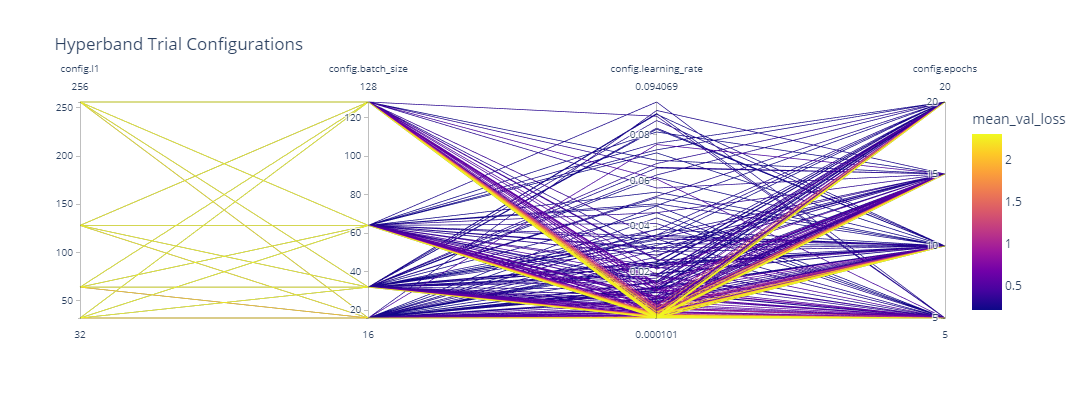

In [14]:
fig = px.parallel_coordinates(df_flat_e6_log, color="mean_val_loss",
                              title='Hyperband Trial Configurations',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Overview Tested Configurations</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- **SMBO** makes interdependencies less visible here due to focus on finding improved configurations.

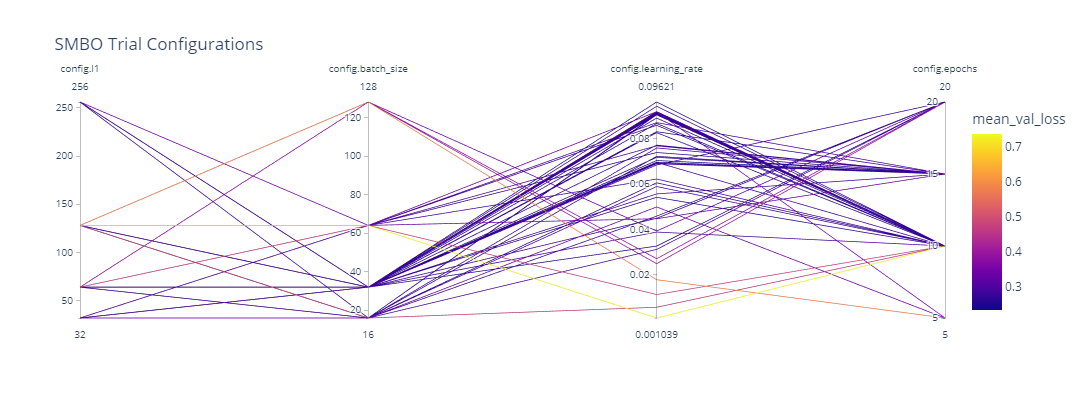

In [15]:
fig = px.parallel_coordinates(df_flat_e8, color="mean_val_loss",
                              title='SMBO Trial Configurations',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Overview Tested Configurations</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- **Random Search** provides a big picture perspective across the whole search space.

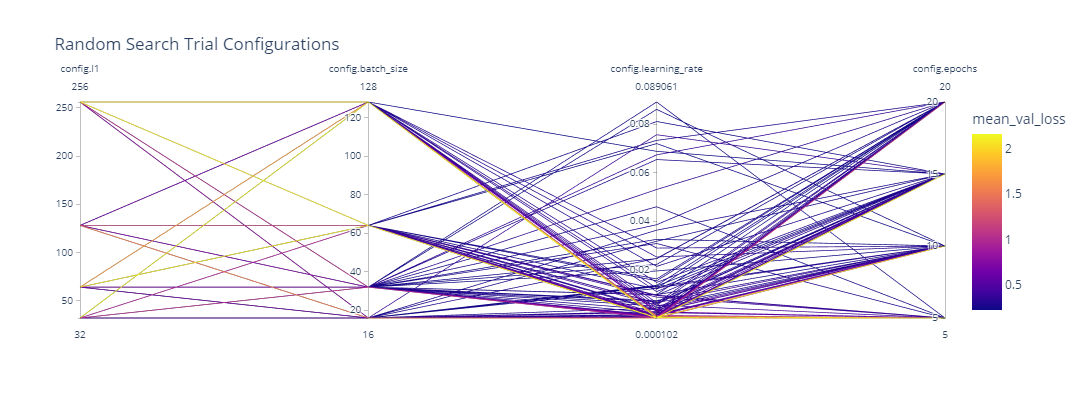

In [16]:
fig = px.parallel_coordinates(df_flat_e7_log, color="mean_val_loss",
                              title='Random Search Trial Configurations',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Units in Layer 1 vs. Batch Size</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- \# of _Units in Layer 1_ does have very little influence on results
- bigger _Batch Size_ with no other configuration changes requires more resources but does not help performance

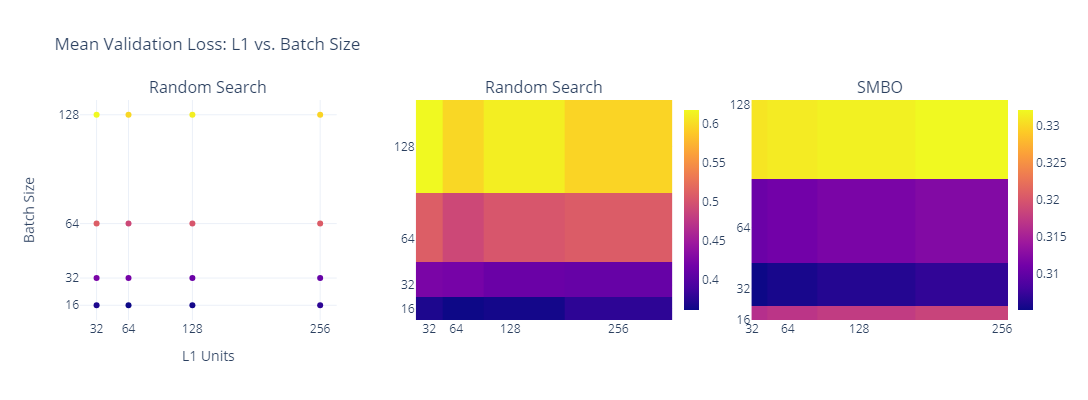

In [17]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["Random Search", "Random Search", "SMBO"], horizontal_spacing=0.085)

plot = go.Scatter(
    x=df_flat_e2['config.l1'], 
    y=df_flat_e2['config.batch_size'], 
    marker_color=df_flat_e2['mean_val_loss'], 
    mode='markers')
fig.add_trace(plot, row=1, col=1)

plot = go.Heatmap(
    z=[df_flat_e2[df_flat_e2['config.batch_size']==x]['mean_val_loss'].tolist() for x in df_flat_e2['config.batch_size'].unique()],
    x=df_flat_e2['config.l1'].unique(),
    y=df_flat_e2['config.batch_size'].unique(),
    #zsmooth='best',
    coloraxis='coloraxis'
)
fig.add_trace(plot, row=1, col=2)

def getHPIndex(name):
    map = [(i, x[0]) for i, x in enumerate(spotTuner_e8.print_importance(print_screen=False))]
    return [x[0] for x in map if x[1] == name][0]

# lower and upper
i = getHPIndex('l1')
j = getHPIndex('batch_size')
x = np.linspace(spotTuner_e8.lower[i], spotTuner_e8.upper[i], num=50)
y = np.linspace(spotTuner_e8.lower[j], spotTuner_e8.upper[j], num=50)
X, Y = meshgrid(x, y)
# Predict based on the optimized results
z0 = np.mean(np.array([spotTuner_e8.lower, spotTuner_e8.upper]), axis=0)
zz = array([spotTuner_e8.surrogate.predict(array([spotTuner_e8.chg(x, y, z0, i, j)])) for x, y in zip(ravel(X), ravel(Y))])
zs = zz[:, 0]
Z = zs.reshape(X.shape)
min_z = np.min(Z)
max_z = np.max(Z)
plot = go.Heatmap(
    z=Z,
    x=[2**val for val in x],
    y=[2**val for val in y],
    #zsmooth='best',
    coloraxis='coloraxis2'
)
fig.add_trace(plot, row=1, col=3)

fig.update_xaxes(
    title = 'L1 Units',
    tickmode = 'array',
    tickvals = df_flat_e2['config.l1'].unique(),
    row=1, col=1
)
fig.update_yaxes(
    title = 'Batch Size',
    tickmode = 'array',
    tickvals = df_flat_e2['config.batch_size'].unique(),
    row=1, col=1
)
fig.update_xaxes(
    tickmode = 'array',
    tickvals = df_flat_e2['config.l1'].unique(),
    row=1, col=2
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e2['config.batch_size'].unique(),
    row=1, col=2
)

fig.update_xaxes(
    tickmode = 'array',
    tickvals = df_flat_e2['config.l1'].unique(),
    row=1, col=3
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e2['config.batch_size'].unique(),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorbar_x=0.64, colorbar_thickness=15),
                  coloraxis2=dict(colorbar_x=1, colorbar_thickness=15))

fig.update_layout(title='Mean Validation Loss: L1 vs. Batch Size', showlegend=False, width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Tested Configurations Overview</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- **Random Search** provides a big picture perspective across the whole search space.

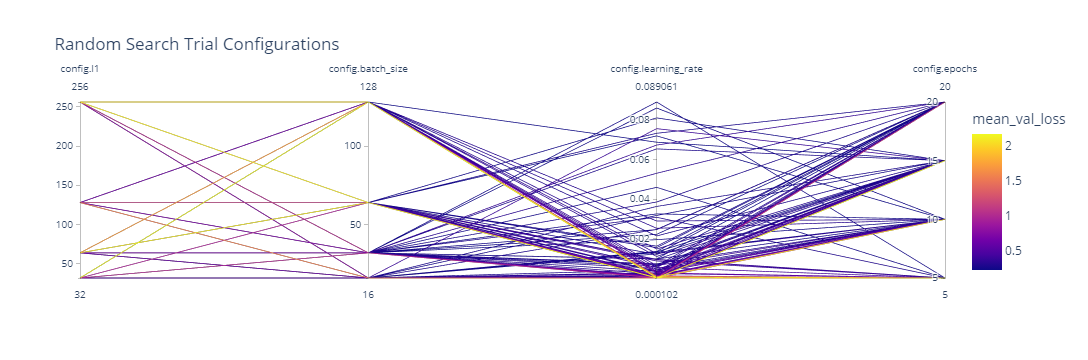

In [18]:
fig = px.parallel_coordinates(df_flat_e7_log, color="mean_val_loss",
                              title='Random Search Trial Configurations',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Batch Size vs. Epochs</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- together determine number of training steps and therefore influence runtime
- large _Batch Size_ and few _Epochs_ does not work
- Choosing a smaller _Batch Size_ and training longer leads to better model performance

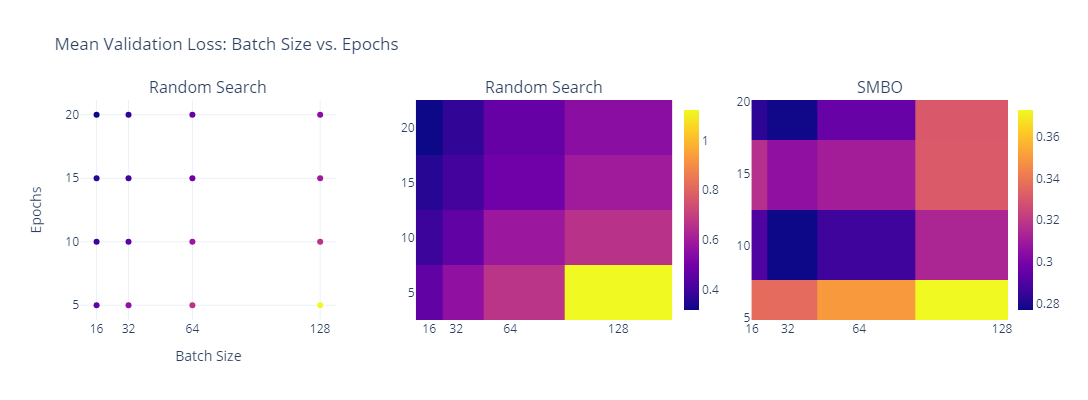

In [19]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["Random Search", "Random Search", "SMBO"], horizontal_spacing=0.085)

plot = go.Scatter(
    x=df_flat_e3['config.batch_size'], 
    y=df_flat_e3['config.epochs'], 
    marker_color=df_flat_e3['mean_val_loss'], 
    mode='markers')
fig.add_trace(plot, row=1, col=1)

plot = go.Heatmap(
    z=[df_flat_e3[df_flat_e3['config.epochs']==x]['mean_val_loss'].tolist() for x in df_flat_e3['config.epochs'].unique()],
    x=df_flat_e3['config.batch_size'].unique(),
    y=df_flat_e3['config.epochs'].unique(),
    #zsmooth='best',
    coloraxis='coloraxis'
)
fig.add_trace(plot, row=1, col=2)

def getHPIndex(name):
    map = [(i, x[0]) for i, x in enumerate(spotTuner_e8.print_importance(print_screen=False))]
    return [x[0] for x in map if x[1] == name][0]

# lower and upper
i = getHPIndex('batch_size')
j = getHPIndex('epochs')
x = np.linspace(spotTuner_e8.lower[i], spotTuner_e8.upper[i], num=50)
y = np.linspace(spotTuner_e8.lower[j], spotTuner_e8.upper[j], num=50)
X, Y = meshgrid(x, y)
# Predict based on the optimized results
z0 = np.mean(np.array([spotTuner_e8.lower, spotTuner_e8.upper]), axis=0)
zz = array([spotTuner_e8.surrogate.predict(array([spotTuner_e8.chg(x, y, z0, i, j)])) for x, y in zip(ravel(X), ravel(Y))])
zs = zz[:, 0]
Z = zs.reshape(X.shape)
min_z = np.min(Z)
max_z = np.max(Z)
plot = go.Heatmap(
    z=Z,
    x=[2**val for val in x],
    y=[(val+1)*5 for val in y],
    #zsmooth='best',
    coloraxis='coloraxis2'
)
fig.add_trace(plot, row=1, col=3)

fig.update_xaxes(
    title = 'Batch Size',
    tickmode = 'array',
    tickvals = df_flat_e3['config.batch_size'].unique(),
    row=1, col=1
)
fig.update_yaxes(
    title = 'Epochs',
    tickmode = 'array',
    tickvals = df_flat_e3['config.epochs'].unique(),
    row=1, col=1
)
fig.update_xaxes(
    tickmode = 'array',
    tickvals = df_flat_e3['config.batch_size'].unique(),
    row=1, col=2
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e3['config.epochs'].unique(),
    row=1, col=2
)

fig.update_xaxes(
    tickmode = 'array',
    tickvals = df_flat_e3['config.batch_size'].unique(),
    row=1, col=3
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e3['config.epochs'].unique(),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorbar_x=0.64, colorbar_thickness=15),
                  coloraxis2=dict(colorbar_x=1, colorbar_thickness=15))

fig.update_layout(title='Mean Validation Loss: Batch Size vs. Epochs', showlegend=False, width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Tested Configurations Overview</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>


- **Random Search** provides a big picture perspective across the whole search space.
- <span style="color: #ff6900;">... why are there so many small _Learning Rate_ configurations tested?</span>

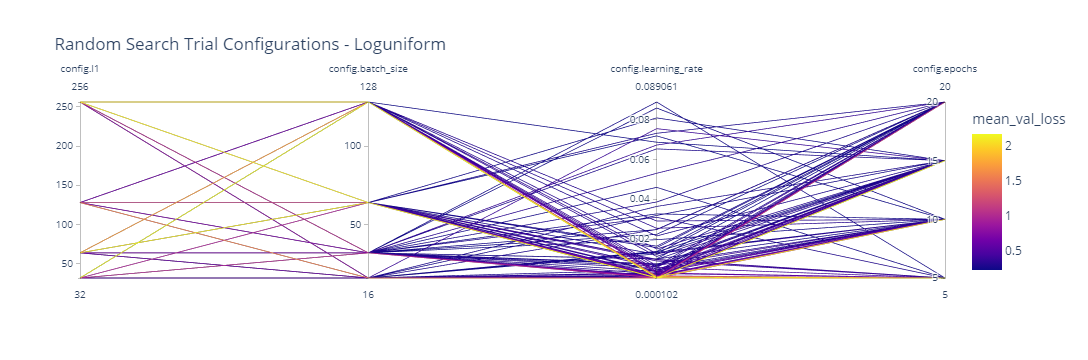

In [20]:
fig = px.parallel_coordinates(df_flat_e7_log, color="mean_val_loss",
                              title='Random Search Trial Configurations - Loguniform',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Tested Configurations Overview</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- **Random Search** provides a big picture perspective across the whole search space.
- <span style="color: #ff6900;">... why are there so many small _Learning Rate_ configurations tested?</span>

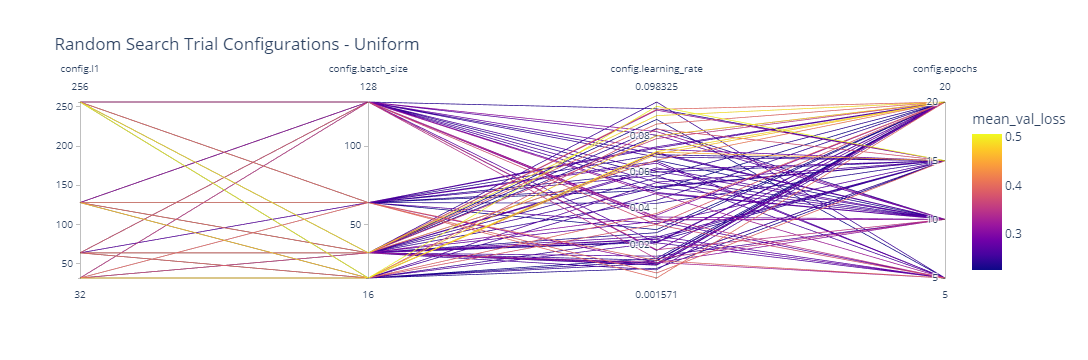

In [21]:
fig = px.parallel_coordinates(df_flat_e7, color="mean_val_loss",
                              title='Random Search Trial Configurations - Uniform',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="font-weight: bold; font-size: 20px;">Learning Rate Sampling Approaches</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- Uniform distribution sampling explores a broad range of values while Loguniform focuses on a range of learning rates that span multiple orders of magnitude <br/>-> beneficial as it's common in DL that values on a logarithmic scale work well
- Uniform sampling helps to assess the sensitivity to specific learning rates, but is more resource-intensive compared to tuning with Loguniform

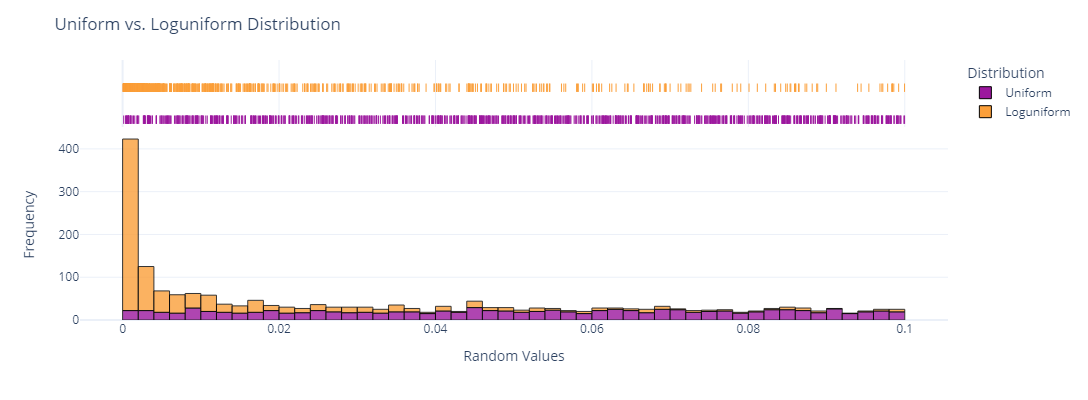

In [22]:
# Generate random samples from a uniform distribution
num_samples = 1000
uniform_samples = np.random.uniform(1e-4, 1e-1, num_samples)

# Generate random samples from a loguniform distribution
loguniform_samples = np.exp(np.random.uniform(np.log(1e-4), np.log(1e-1), num_samples))

# Create a combined dataset for plotting
data = {
    "Random Samples": np.concatenate([uniform_samples, loguniform_samples]),
    "Distribution": np.concatenate([["Uniform"] * num_samples, ["Loguniform"] * num_samples])
}

# Create a histogram using Plotly Express
fig = px.histogram(
    data_frame=data,
    x="Random Samples",
    color="Distribution",
    nbins=50,
    opacity=0.8,
    marginal="rug",
    color_discrete_sequence=[colors[1], colors[3]]
)

# Customize the layout
fig.update_layout(
    title="Uniform vs. Loguniform Distribution",
    xaxis_title="Random Values",
    yaxis_title="Frequency",
    width=900,
    height=400
)
fig.update_traces(marker_line_width=1,marker_line_color="black")
# Show the plot
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Learning Rate vs. Batch Size</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- larger _Batch Sizes_ work better with a higher _Learning Rate_
- very high _Learning Rates_ are not beneficial

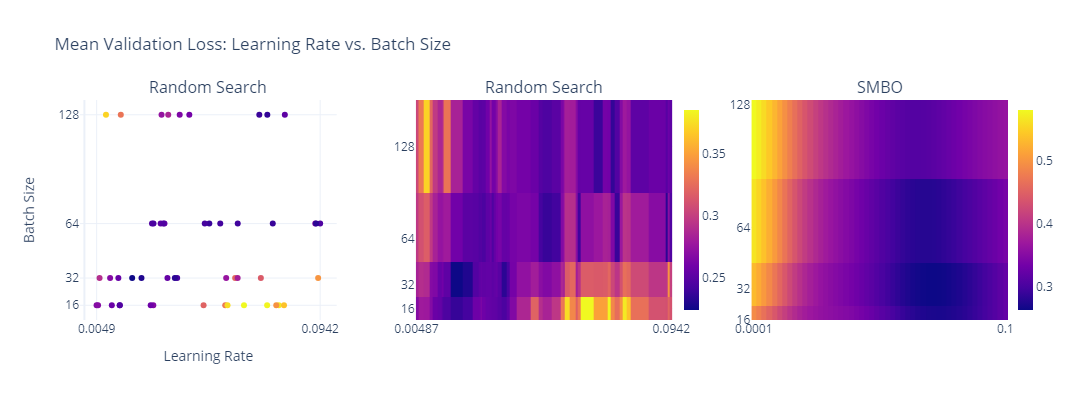

In [23]:
min = np.array(df_flat_e5['config.learning_rate']).min()
max = np.array(df_flat_e5['config.learning_rate']).max()

fig = make_subplots(rows=1, cols=3, subplot_titles=["Random Search", "Random Search", "SMBO"], horizontal_spacing=0.085)

plot = go.Scatter(
    x=df_flat_e5['config.learning_rate'], 
    y=df_flat_e5['config.batch_size'], 
    marker_color=df_flat_e5['mean_val_loss'], 
    mode='markers')
fig.add_trace(plot, row=1, col=1)

z = pd.pivot_table(df_flat_e5, values=['mean_val_loss'], index=['config.batch_size'], columns=['config.learning_rate'], fill_value=None, dropna=False).to_numpy()
plot = go.Heatmap(
    z=z,
    x=sorted(df_flat_e5['config.learning_rate'].unique()),
    y=sorted(df_flat_e5['config.batch_size'].unique()),
    #zsmooth='best',
    connectgaps=True,
    coloraxis='coloraxis'
)
fig.add_trace(plot, row=1, col=2)

def getHPIndex(name):
    map = [(i, x[0]) for i, x in enumerate(spotTuner_e8.print_importance(print_screen=False))]
    return [x[0] for x in map if x[1] == name][0]

# lower and upper
i = getHPIndex('lr_mult')
j = getHPIndex('batch_size')
x = np.linspace(spotTuner_e8.lower[i], spotTuner_e8.upper[i], num=50)
y = np.linspace(spotTuner_e8.lower[j], spotTuner_e8.upper[j], num=50)
X, Y = meshgrid(x, y)
# Predict based on the optimized results
z0 = np.mean(np.array([spotTuner_e8.lower, spotTuner_e8.upper]), axis=0)
zz = array([spotTuner_e8.surrogate.predict(array([spotTuner_e8.chg(x, y, z0, i, j)])) for x, y in zip(ravel(X), ravel(Y))])
zs = zz[:, 0]
Z = zs.reshape(X.shape)
min_z = np.min(Z)
max_z = np.max(Z)
plot = go.Heatmap(
    z=Z,
    x=[val*1e-3 for val in x],
    y=[2**val for val in y],
    #zsmooth='best',
    coloraxis='coloraxis2'
)
fig.add_trace(plot, row=1, col=3)

fig.update_xaxes(
    title = 'Learning Rate',
    tickmode = 'array',
    tickvals = [round(min, 4), round(max, 4)],
    ticktext = [round(min, 4), round(max, 4)],
    row=1, col=1
)
fig.update_yaxes(
    title = 'Batch Size',
    tickmode = 'array',
    tickvals = df_flat_e5['config.batch_size'].unique(),
    row=1, col=1
)
fig.update_xaxes(
    tickmode = 'array',
    tickvals = [round(min, 5), round(max, 4)],
    ticktext = [round(min, 5), round(max, 4)],
    row=1, col=2
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e5['config.batch_size'].unique(),
    row=1, col=2
)

fig.update_xaxes(
    tickmode = 'array',
    tickvals = [1e-4, 1e-1],
    ticktext = [1e-4, 1e-1],
    row=1, col=3
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e5['config.batch_size'].unique(),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorbar_x=0.64, colorbar_thickness=15),
                  coloraxis2=dict(colorbar_x=1, colorbar_thickness=15))

fig.update_layout(title='Mean Validation Loss: Learning Rate vs. Batch Size', showlegend=False, width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Tested Configurations Overview</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- **Random Search** provides a big picture perspective across the whole search space.

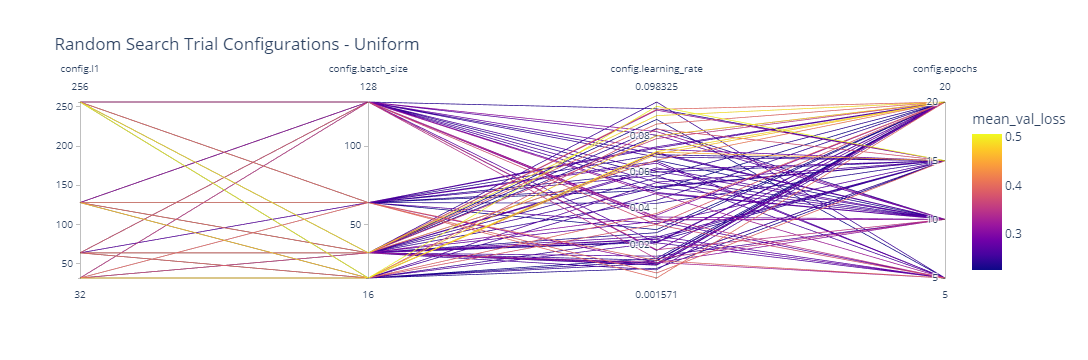

In [24]:
fig = px.parallel_coordinates(df_flat_e7, color="mean_val_loss",
                              title='Random Search Trial Configurations - Uniform',
                              dimensions=['config.l1', 'config.batch_size', 'config.learning_rate',
                                          'config.epochs'], width=900)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Learning Rate vs. Epochs</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- training with a small _Learning Rate_ over more _Epochs_ leads to better results
- when training for less _Epochs_ a larger _Learning Rate_ can be selected
- five _Epochs_ seems to be not enough in general

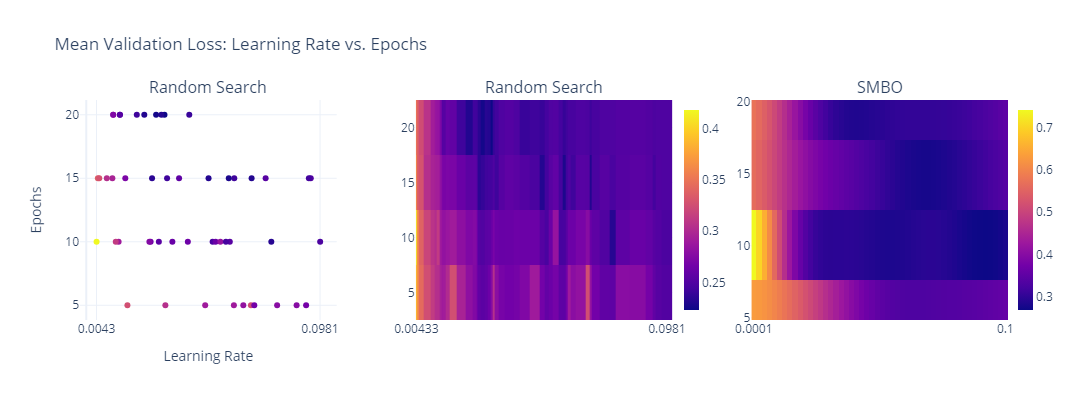

In [25]:
min = np.array(df_flat_e4['config.learning_rate']).min()
max = np.array(df_flat_e4['config.learning_rate']).max()

fig = make_subplots(rows=1, cols=3, subplot_titles=["Random Search", "Random Search", "SMBO"], horizontal_spacing=0.085)

plot = go.Scatter(
    x=df_flat_e4['config.learning_rate'], 
    y=df_flat_e4['config.epochs'], 
    marker_color=df_flat_e4['mean_val_loss'], 
    mode='markers')
fig.add_trace(plot, row=1, col=1)

z = pd.pivot_table(df_flat_e4, 
        values=['mean_val_loss'], 
        index=['config.epochs'], 
        columns=['config.learning_rate'], fill_value=None, dropna=False).to_numpy()
plot = go.Heatmap(
    z=z,
    x=sorted(df_flat_e4['config.learning_rate'].unique()),
    y=sorted(df_flat_e4['config.epochs'].unique()),
    #zsmooth='best',
    connectgaps=True,
    coloraxis='coloraxis'
)
fig.add_trace(plot, row=1, col=2)

def getHPIndex(name):
    map = [(i, x[0]) for i, x in enumerate(spotTuner_e8.print_importance(print_screen=False))]
    return [x[0] for x in map if x[1] == name][0]

# lower and upper
i = getHPIndex('lr_mult')
j = getHPIndex('epochs')
x = np.linspace(spotTuner_e8.lower[i], spotTuner_e8.upper[i], num=50)
y = np.linspace(spotTuner_e8.lower[j], spotTuner_e8.upper[j], num=50)
X, Y = meshgrid(x, y)
# Predict based on the optimized results
z0 = np.mean(np.array([spotTuner_e8.lower, spotTuner_e8.upper]), axis=0)
zz = array([spotTuner_e8.surrogate.predict(array([spotTuner_e8.chg(x, y, z0, i, j)])) for x, y in zip(ravel(X), ravel(Y))])
zs = zz[:, 0]
Z = zs.reshape(X.shape)
min_z = np.min(Z)
max_z = np.max(Z)
plot = go.Heatmap(
    z=Z,
    x=[val*1e-3 for val in x],
    y=[(val+1)*5 for val in y],
    #zsmooth='best',
    coloraxis='coloraxis2'
)
fig.add_trace(plot, row=1, col=3)

fig.update_xaxes(
    title = 'Learning Rate',
    tickmode = 'array',
    tickvals = [round(min, 4), round(max, 4)],
    ticktext = [round(min, 4), round(max, 4)],
    row=1, col=1
)
fig.update_yaxes(
    title = 'Epochs',
    tickmode = 'array',
    tickvals = df_flat_e4['config.epochs'].unique(),
    row=1, col=1
)
fig.update_xaxes(
    tickmode = 'array',
    tickvals = [round(min, 5), round(max, 4)],
    ticktext = [round(min, 5), round(max, 4)],
    row=1, col=2
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e4['config.epochs'].unique(),
    row=1, col=2
)

fig.update_xaxes(
    tickmode = 'array',
    tickvals = [1e-4, 1e-1],
    ticktext = [1e-4, 1e-1],
    row=1, col=3
)
fig.update_yaxes(
    tickmode = 'array',
    tickvals = df_flat_e4['config.epochs'].unique(),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorbar_x=0.64, colorbar_thickness=15),
                  coloraxis2=dict(colorbar_x=1, colorbar_thickness=15))

fig.update_layout(title='Mean Validation Loss: Learning Rate vs. Epochs', showlegend=False, width=900, height=400)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Influence of Hyperparameters</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- SMBO calculated importance supports previous observations
- adjusting _Learning Rate_ and _Epochs_ is more significant than changing _Batch Size_ or the # of hidden _Units in the L1 Layer_

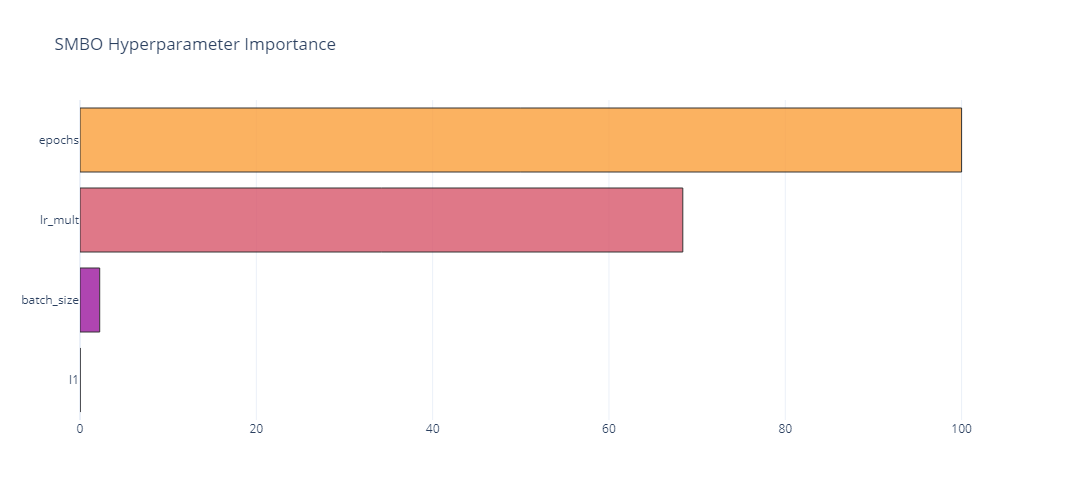

In [26]:
theta = np.power(10, spotTuner_e8.surrogate.theta)
imp = 100 * theta / np.max(theta)
idx = np.where(imp > 0.001)[0]
var_name = [spotTuner_e8.var_name[i] for i in idx]
comb = sorted(zip(var_name, imp), key = lambda t: t[1])
names = [x[0] for x in comb]
impo = [x[1] for x in comb]

fig = go.Figure([go.Bar(y=names, 
                        x=impo,         
                        marker_color=colors,
                        marker_line_color='black',
                        marker_line_width=1,
                        opacity=0.8,
                        orientation='h')])
fig.update_layout(title="SMBO Hyperparameter Importance",
                    width=900,
                    height=500)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 35px; font-weight: bold;">Performance Comparison</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="color: #ff6900; font-weight: bold; font-size: 25px;">Overall Accuracy Score Improvement</p>

- achieving better overall accuracy than default configuration after hyperparameter tuning
- only small performance deviations between different tuning approaches and results <br/>-> expected 'cos also quite similar best configurations

Best Configurations

In [27]:
means = [default_reps.overall.median() * 100, e7_reps.overall.median() * 100, e6_reps.overall.median() * 100, e8_reps.overall.median() * 100]
df = pd.read_csv(f'{eval_data_path}/best_config.csv', index_col=0)
df["Overall Acc."] = means
df.style.format({
  'Overall Acc.': lambda val: f'{val:,.2f} %',
})

,L1 Units,Batch Size,Epochs,Learning Rate,# Trials,Overall Acc.
Default,64,64,15,0.001000,-,81.99 %
Random Search,128,16,10,0.054035,87 (~6h),91.73 %
Hyperband,128,16,15,0.098538,340 (~6h),90.73 %
SMBO,256,32,10,0.091179,68 (~6h),91.61 %


<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Overall Accuracy Score Improvement</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- achieving better overall accuracy than default configuration after hyperparameter tuning
- only small performance deviations between different tuning approaches and results <br/>-> expected 'cos also quite similar best configurations

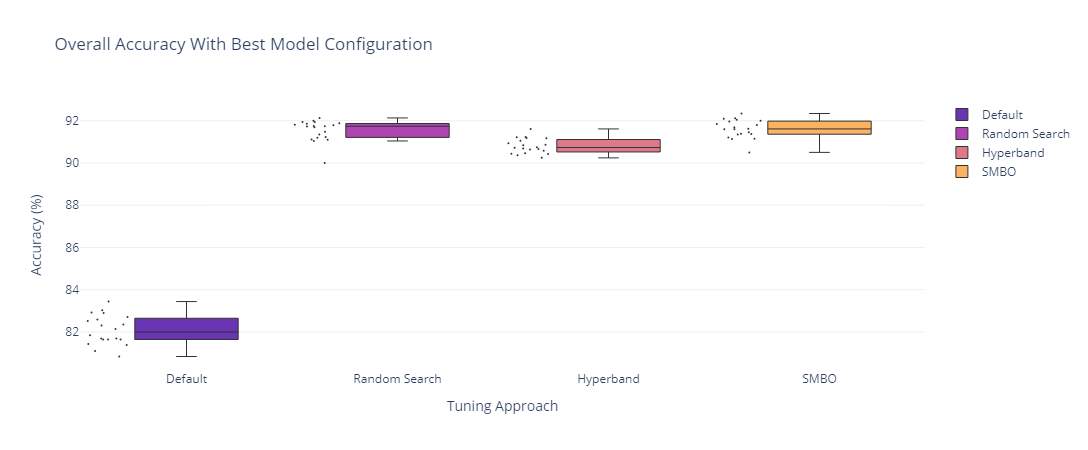

In [28]:
x_data = ['Default', 'Random Search', 'Hyperband', 'SMBO']
y_data = [default_reps['overall'] * 100, e7_reps['overall'] * 100, e6_reps['overall'] * 100, e8_reps['overall'] * 100]
# colors = ['#1b0c41','#781c6d','#cf4446','#fb9b06',]
colors = ['#46039f','#9c179e','#d8576b','#fb9f3a']

fig = go.Figure()
for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            opacity=0.8,
            marker_size=2,
            marker_color='black',
            line_width=1)
        )
fig.update_layout(
    title='Overall Accuracy With Best Model Configuration',
    yaxis_title='Accuracy (%)',
    xaxis_title='Tuning Approach',
    showlegend=True,
    width=900,
    height=450
)
fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-weight: bold; font-size: 25px;">Per Class Accuracy Score Improvement</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

- default configuration struggles with some classes in particular (Pullover, Shirt, etc.)
- no single configuration is best in classifying all different types of fashion items

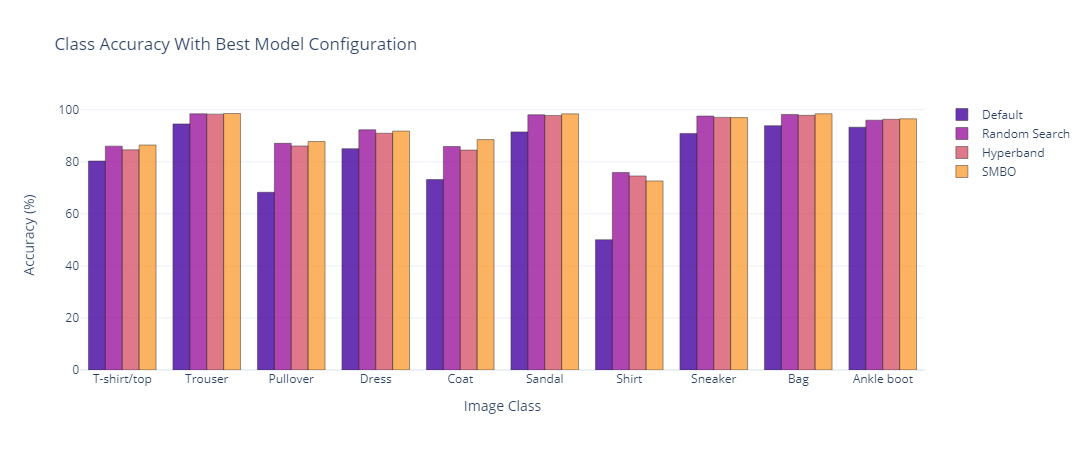

In [29]:
fig = go.Figure()
names = ['Default', 'Random Search', 'Hyperband', 'SMBO']
colors = ['#46039f','#9c179e','#d8576b','#fb9f3a']
for i, df in enumerate([default_reps, e7_reps, e6_reps, e8_reps]):
    fig.add_trace(go.Bar(
        x=class_names,
        y=[df.loc[:, name].mean() for name in class_names],
        name=names[i],
        marker_color=colors[i],
        marker_line_color='black',
        opacity=0.8
    ))

fig.update_layout(
    title='Class Accuracy With Best Model Configuration',
    xaxis_title='Image Class',
    yaxis_title='Accuracy (%)',
    barmode='group',
    width=900,
    height=450,
    showlegend=True,
)

fig.show()

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 40px; font-weight: bold;">Conclusion</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>
<p style="font-size: 18px;"><i>Providing a Summary and Key Takeaways, as well as offering Insights and Recommendations for Future Work</i></p>

<span style="color: #ff6900; font-size: 25px; font-weight: bold;">Key Takeaways</span>
<ul>
    <li>Project shows the importance of fine-tuning for achieving better performance</li>
    <li>The utilization of three distinct approaches - Random Search, Hyperband, and SMBO - provided comprehensive insights into the various methodologies of tuning and collectively contributed to a deeper understanding.</li>
    <li>Fashion-MNIST is a valuable benchmark dataset for such experiments</li>
    <li>learning_rate is a very sensitive hyperparameter</li>
    <li>l1 hyperparameter is not so sensitive in this use case </li>
    <li>The kind of sampling for the hyperparameter plays a role</li>
    <li>Mostly no general accepted default hyperparemters for DNNs</li>
    <li>Trade-Off Performance vs. Runtime</li>
    <li>Risk of Overfitting</li>
    <li>Ease of Implementation (Random Search -> SMBO)</li>
</ul>

<div style="display: flex; justify-content: space-between; align-items: center; width: 100%;">
    <span style="color: #ff6900; font-size: 25px; font-weight: bold;">Outlook</span>
    <span style="text-align: right; font-size: 12px;">Lena Hammerer | Luisa Ibele | Hanna Steinwender</span>
</div>

<ul>
    <li>Looking at further parameters like optimizer or dropout</li>
    <li>Consider other metrics like precision, recall, F1-score or the confusion matrix in general</li>
    <li>Explore other techniques like Neural Architecture Search or Ensemble Methods</li>
    <li>Assess the transferability of insights gained from the hyperparameter tuning on Fashion MNIST to other image classification datasets</li>
</ul>

<span style="color: #ff6900; font-size: 40px; font-weight: bold;">References</span>
<ul style="font-size: 12px;">
    <li>Bartz-Beielstein, Thomas. “PyTorch Hyperparameter Tuning - A Tutorial for SpotPython.” June 7, 2023.</li>
    <li>Bartz, E., Bartz-Beielstein, T., Zaefferer, M. and Mersmann, O., 2023. Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide (p. 323). Springer Nature.</li>
    <li>Bergstra, James, and Y. Bengio. “Random Search for Hyper-Parameter Optimization.” The Journal of Machine Learning Research 13 (March 2012): 281–305.</li>
    <li>Brownlee, J., 2018. What is the Difference Between a Batch and an Epoch in a Neural Network. Machine Learning Mastery, 20.</li>
    <li>Grandini, M., Bagli, E. and Visani, G., 2020. Metrics for multi-class classification: an overview. arXiv preprint arXiv:2008.05756.</li>
    <li>Johny, A. and Madhusoodanan, K.N., 2021. Dynamic learning rate in deep CNN model for metastasis detection and classification of histopathology images. Computational and Mathematical Methods in Medicine, 2021, pp.1-13.</li>
    <li>Kayed, M., Anter, A. and Mohamed, H., 2020, February. Classification of garments from fashion MNIST dataset using CNN LeNet-5 architecture. In 2020 international conference on innovative trends in communication and computer engineering (ITCE) (pp. 238-243). IEEE.</li>
    <li>Li, Lisha, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, and Ameet Talwalkar. “Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization.” June 18, 2018.</li>
    <li>Li, Lisha, Kevin Jamieson, Afshin Rostamizadeh, Katya Gonina, Moritz Hardt, Benjamin Recht, and Ameet Talwalkar. “Massively Parallel Hyperparameter Tuning,” February 15, 2018.</li>
    <li>Meshkini, K., Platos, J. and Ghassemain, H., 2020. An analysis of convolutional neural network for fashion images classification (fashion-mnist). In Proceedings of the Fourth International Scientific Conference “Intelligent Information Technologies for Industry”(IITI’19) 4 (pp. 85-95). Springer International Publishing.</li>
    <li>Mishra, Prafful (2019): Why are Convolutional Neural Networks good for image classification? In: DataDrivenInvestor (27.05.2019) - URL https://medium.datadriveninvestor.com/why-are-convolutional-neural-networks-good-for-image-classification-146ec6e865e8, Accessed: 31.08.2023.</li>
    <li>Tuba, E., Bačanin, N., Strumberger, I. and Tuba, M., 2021. Convolutional neural networks hyperparameters tuning. In Artificial intelligence: theory and applications (pp. 65-84). Cham: Springer International Publishing.</li>
    <li>White, C., Safari, M., Sukthanker, R., Ru, B., Elsken, T., Zela, A., Dey, D. and Hutter, F., 2023. Neural architecture search: Insights from 1000 papers. arXiv preprint arXiv:2301.08727.</li>
    <li>Xiao, H., Rasul, K. and Vollgraf, R., 2017. Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. arXiv preprint arXiv:1708.07747.</li>
    <li>Zhang, Z. and Sabuncu, M., 2018. Generalized cross entropy loss for training deep neural networks with noisy labels. Advances in neural information processing systems, 31.</li>
</ul>